In [1]:
from charm.toolbox.pairinggroup import PairingGroup, ZR, G1, G2, GT, pair
from charm.toolbox.ABEnc import ABEnc
#from abenc_ph_mj18 import PH_ABE, mat_math, Inner_Product

In [2]:
from nizk import NIZK
from benchmark import Benchmark
from collections import defaultdict 
import time
import matplotlib.pyplot as plt
import numpy as np

/home/guy1m0/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [ ]:
#ss512 and mnt159 both provides 80-bit security level

## Test New

In [2]:
from charm.toolbox.pairinggroup import PairingGroup, ZR, G1, G2, GT, pair
from charm.toolbox.ABEnc import ABEnc
from abenc_tf22 import DIPE_ABE, Inner_Product
group = PairingGroup('SS512')
n = 5
dipe = DIPE_ABE(n, group)

In [3]:
attributes = Inner_Product(group)
vec_x,vec_y = attributes.gen_x_y(n,[1,2])
sum([x*y for x,y in zip(vec_x,vec_y)])

0

In [4]:
pp = dipe.setup()

In [5]:
pks, sks = dipe.auth_setup(pp)

In [6]:
GID = group.random(ZR)

In [8]:
D0, D1, K = dipe.keygen(pp, pks, sks, GID, vec_x)

In [9]:
M = group.random(GT)

In [10]:
C = dipe.encrypt(pp, pks, vec_y, M)

In [11]:
M

[4233653572184785866027081348577722086234845883964441888361542499591467895558701472800421298521732190838677015689349673595509242034119189646537758318618119, 1669487019913763244325666481478235424031222143809640395781684104637912430862749176017678799270299075229875753515329128423611047925448123883055743056468498]

In [12]:
dipe.decrypt(D0, D1, K, C, vec_y)

[5551999956707603953020610821844663955988813176356254613614751091122382009645889733188269689080641193713892230962528625559258190997971172888715053350817281, 6472230205632484234795510920380880349769385138799556206095606165157962206029756402948992382804145419517195298972980142992412901965029631923958503192583532]

## Benchmarking

In [3]:
ben = Benchmark(PairingGroup('MNT224'))
datasets = defaultdict(str)

In [4]:
xs = range(5,65,3)
datasets = ben.benchmark_scheme(2, xs, datasets)
datasets = ben.benchmark_scheme(3, xs, datasets)

---------------- 5 -----------------------
AA's cost:  0.05590744018554688
AA's extra cost:  0.181412935256958
DO's cost:  0.0556640625
DU's cost:  0.022541046142578125
Ad's cost:  0.041969823837280276
Original Sys cost:  0.3710160255432129
Enhanced Sys cost:  0.6194345951080322
---------------- 8 -----------------------
AA's cost:  0.0684390664100647
AA's extra cost:  0.28212642669677734
DO's cost:  0.07668042182922363
DU's cost:  0.02272963523864746
Ad's cost:  0.055973201990127563
Original Sys cost:  0.6596639156341553
Enhanced Sys cost:  1.059422254562378
---------------- 11 -----------------------
AA's cost:  0.0812318975275213
AA's extra cost:  0.3851313591003418
DO's cost:  0.10619091987609863
DU's cost:  0.022937536239624023
Ad's cost:  0.06892199949784712
Original Sys cost:  1.0354151725769043
Enhanced Sys cost:  1.5895841121673584
---------------- 14 -----------------------


KeyboardInterrupt: 

In [18]:
sp_xs = range(5,65,5)
datasets = ben.benchmark_scheme(5, sp_xs, datasets)
datasets = ben.benchmark_scheme(10, sp_xs, datasets)

---------------- 5 -----------------------
AA's cost:  0.07614502906799317
AA's extra cost:  0.2845778465270996
DO's cost:  0.1345524787902832
DU's cost:  0.02535390853881836
Ad's cost:  0.041828346252441403
Original Sys cost:  0.5594055652618408
Enhanced Sys cost:  0.9209237098693848
---------------- 10 -----------------------
AA's cost:  0.08745937347412108
AA's extra cost:  0.6792812347412109
DO's cost:  0.3624286651611328
DU's cost:  0.04511451721191406
Ad's cost:  0.08851690292358398
Original Sys cost:  1.300473928451538
Enhanced Sys cost:  2.153508424758911
---------------- 15 -----------------------
AA's cost:  0.1369236946105957
AA's extra cost:  0.8493225574493408
DO's cost:  0.578850269317627
DU's cost:  0.046146392822265625
Ad's cost:  0.11103696823120117
Original Sys cost:  2.7052338123321533
Enhanced Sys cost:  3.8257040977478027
---------------- 20 -----------------------
AA's cost:  0.17195892333984375
AA's extra cost:  1.0884466171264648
DO's cost:  0.5077733993530273
D

In [6]:
import pickle
with open('data_136K.pkl','wb') as file:
    pickle.dump(datasets, file)

## Ploting


### Each Entity

In [16]:
def plot_entities(k, xs, ys, labels, label_size=18, legend_size=18):
    # Plotting:
    plt.figure(figsize=(10,6))

    # List of linestyles for variation. You can extend this if needed.
    linestyles = ['-.', '--', '-',':']
    sp_linestyles = ['-.', ':', '-']
    
    # Plotting the regular data points for each k_value
    for y, label, style in zip(ys, labels, linestyles):
        #print (xs, y)
        plt.plot(xs, y, label=f'{label}', linestyle=style)

    # Setting labels, title, legend, etc.
    plt.xlabel('Number of attribute authority', fontsize = label_size)
    plt.ylabel('Elapsed Time (seconds)', fontsize = label_size)
    # plt.title(f'Performance result with fixed k: {k}', fontsize = title_size)
    plt.legend(prop={'size': legend_size})
    plt.grid(True)
    plt.tight_layout()
    #plt.title(title)
    plt.show()

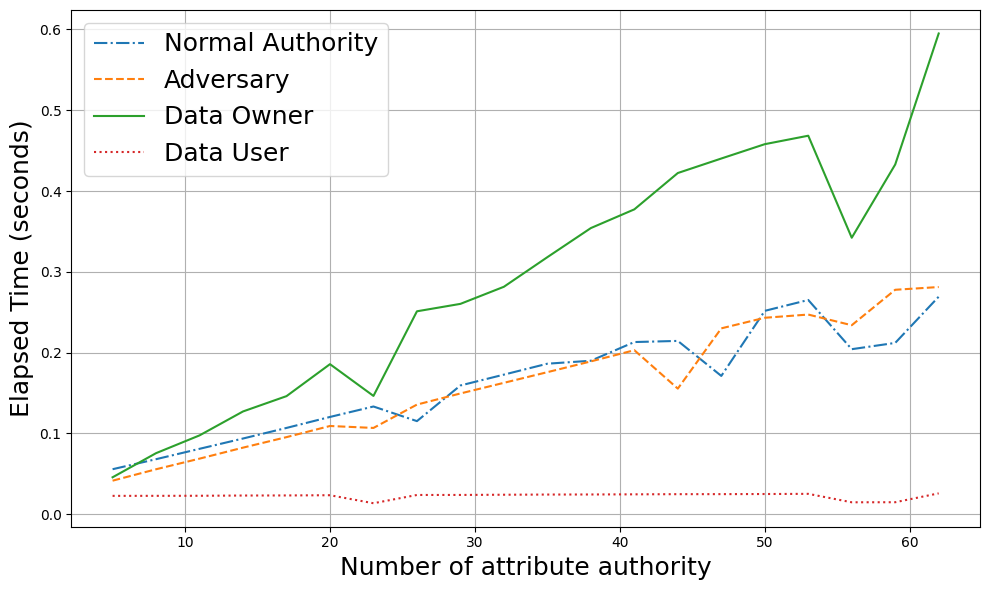

In [21]:
k = 2
xs = range(5,65,3)
ys = [] #AA, Adversary, DO, DU
labels = ["Normal Authority", "Adversary", "Data Owner", "Data User"]
#ys.append([d['total'] for d in datasets[str(ks[0])]['seq']])

ys.append([(d['auth'] + d['keygen'])/i for i,d in zip(xs, datasets[str(k)]['seq'])])
ys.append([d['ad_setup'] + d['ad_cancel_out'] + d['ad_keygen'] for d in datasets[str(k)]['seq']])
ys.append([d['encrypt'] for d in datasets[str(k)]['seq']])
ys.append([d['decrypt'] for d in datasets[str(k)]['seq']])

plot_entities(k, xs, ys, labels)

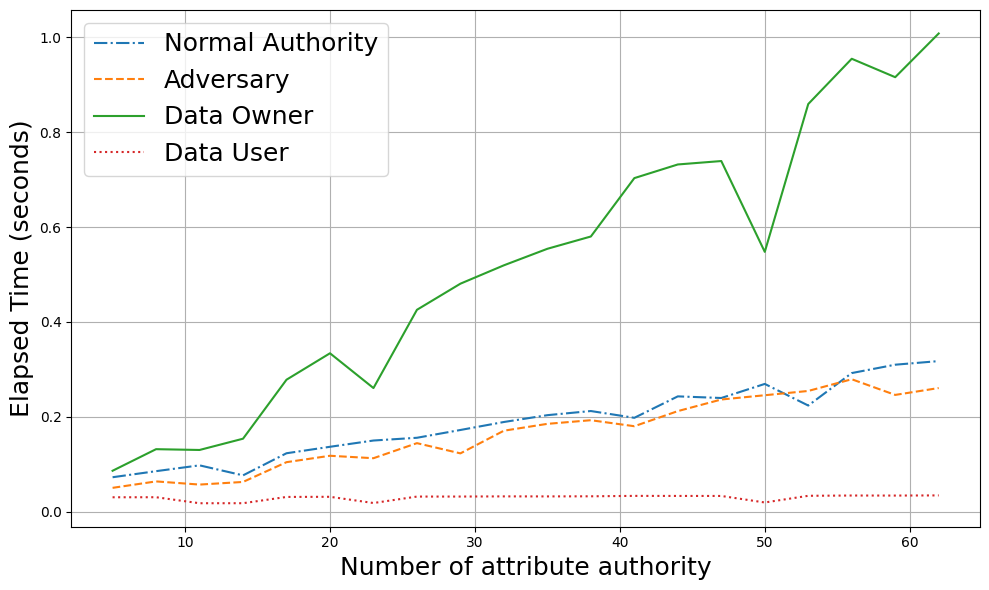

In [22]:
k = 3
xs = range(5,65,3)
ys = [] #AA, Adversary, DO, DU
labels = ["Normal Authority", "Adversary", "Data Owner", "Data User"]
#ys.append([d['total'] for d in datasets[str(ks[0])]['seq']])

ys.append([(d['auth'] + d['keygen'])/i for i,d in zip(xs, datasets[str(k)]['seq'])])
ys.append([d['ad_setup'] + d['ad_cancel_out'] + d['ad_keygen'] for d in datasets[str(k)]['seq']])
ys.append([d['encrypt'] for d in datasets[str(k)]['seq']])
ys.append([d['decrypt'] for d in datasets[str(k)]['seq']])

plot_entities(k, xs, ys, labels)

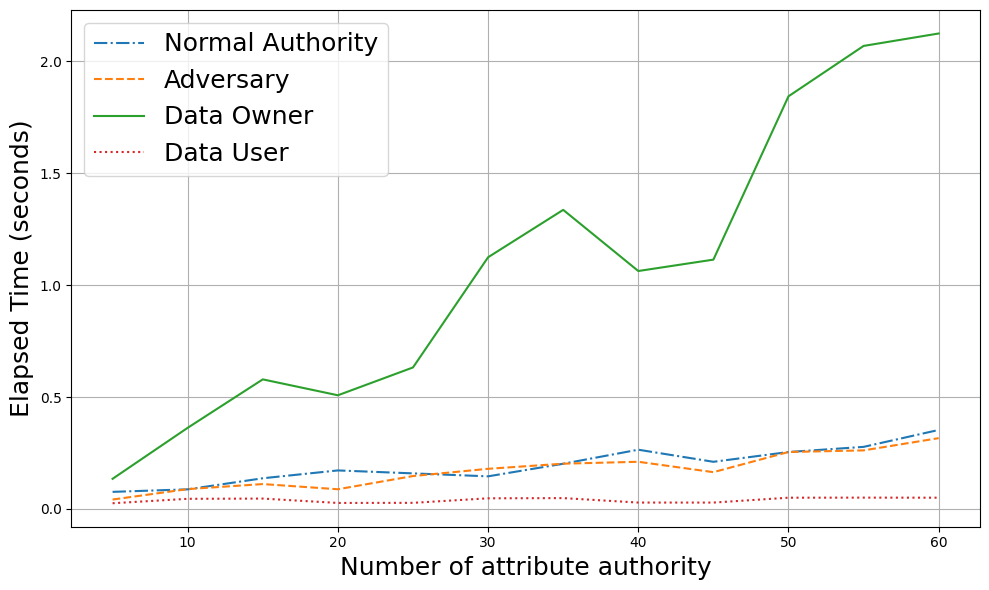

In [23]:
k = 5
xs = range(5,65,5)
ys = [] #AA, Adversary, DO, DU
labels = ["Normal Authority", "Adversary", "Data Owner", "Data User"]
#ys.append([d['total'] for d in datasets[str(ks[0])]['seq']])

ys.append([(d['auth'] + d['keygen'])/i for i,d in zip(xs, datasets[str(k)]['seq'])])
ys.append([d['ad_setup'] + d['ad_cancel_out'] + d['ad_keygen'] for d in datasets[str(k)]['seq']])
ys.append([d['encrypt'] for d in datasets[str(k)]['seq']])
ys.append([d['decrypt'] for d in datasets[str(k)]['seq']])

plot_entities(k, xs, ys, labels)

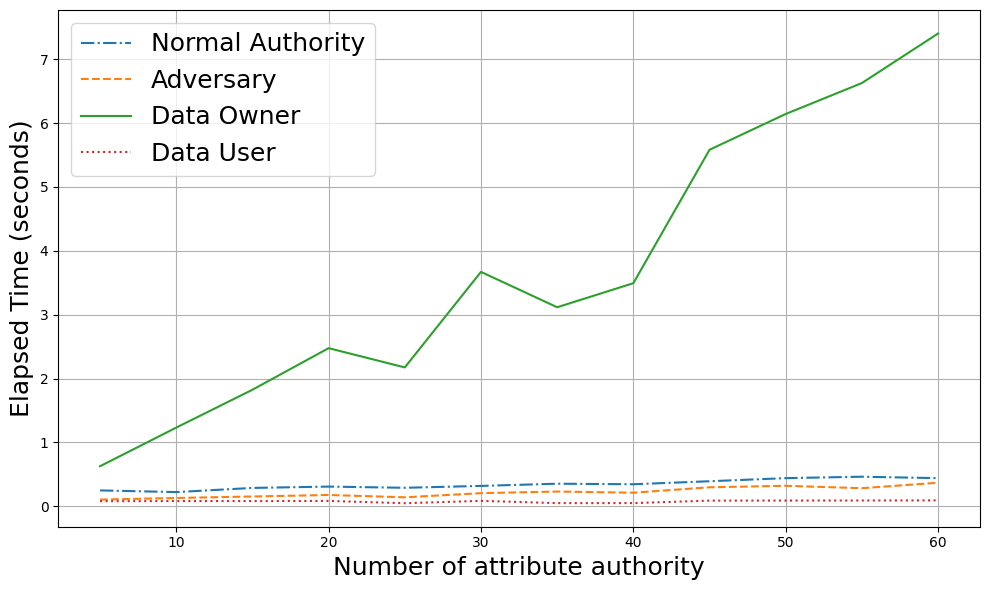

In [24]:
k = 10
xs = range(5,65,5)
ys = [] #AA, Adversary, DO, DU
labels = ["Normal Authority", "Adversary", "Data Owner", "Data User"]
#ys.append([d['total'] for d in datasets[str(ks[0])]['seq']])

ys.append([(d['auth'] + d['keygen'])/i for i,d in zip(xs, datasets[str(k)]['seq'])])
ys.append([d['ad_setup'] + d['ad_cancel_out'] + d['ad_keygen'] for d in datasets[str(k)]['seq']])
ys.append([d['encrypt'] for d in datasets[str(k)]['seq']])
ys.append([d['decrypt'] for d in datasets[str(k)]['seq']])

plot_entities(k, xs, ys, labels)

### Other plots

In [43]:
def plot_linestyle(ks, xs, ys, sp_xs, sp_ys, labels):
    # Plotting:
    plt.figure(figsize=(10,6))

    # List of linestyles for variation. You can extend this if needed.
    linestyles = ['-', '--', ':']
    sp_linestyles = ['-.', ':', '-']
    
    # Plotting the regular data points for each k_value
    for y, label, style in zip(ys, labels, linestyles):
        #print (xs, y)
        plt.plot(xs, y, label=f'{label} with k={ks[0]}', linestyle=style)

    # Plotting the special cases
    for y, label, style in zip(sp_ys, labels, sp_linestyles):
        plt.plot(sp_xs, y, linestyle=style, marker='o', label=f'{label} with k={ks[1]}')

    vlines_x = [45, 85]  # example x-coordinates for the vertical lines

    for vx in vlines_x:
        plt.axvline(x=vx, color='gray', linestyle='--', alpha=0.7)  # draw vertical line
        
        if vx in xs:  # If vx is a value in xs, get its intersection with the regular plots
            idx = xs.index(vx)
            for y in ys:
                rounded_y = round(y[idx], 2)
                #plt.scatter(vx, rounded_y, color='red', zorder=5)
                plt.annotate(f'({vx}, {rounded_y})', (vx, rounded_y), textcoords="offset points", xytext=(0,10), ha='center')
        
        if vx in sp_xs:  # If vx is a value in sp_x, get its intersection with the special plots
            idx_sp = sp_xs.index(vx)
            for y in sp_ys:
                rounded_y_sp = round(y[idx_sp], 2)
                #plt.scatter(vx, rounded_y_sp, color='blue', zorder=5)
                plt.annotate(f'({vx}, {rounded_y_sp})', (vx, rounded_y_sp), textcoords="offset points", xytext=(0,10), ha='center')

    # Setting labels, title, legend, etc.
    plt.xlabel('Size of attribute authority')
    plt.ylabel('Elapsed Time (seconds)')
    #plt.title('Performance based on k-LIN Assumption Size')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.title(title)
    plt.show()


In [8]:
ks = [2,5]

xs = range(5,101,5)
ys = []
ys.append([d['total'] for d in datasets[str(ks[0])]['seq']])
ys.append([d['ad_setup'] + d['ad_cancel_out'] for d in datasets[str(ks[0])]['seq']])
ys.append([(d['auth'] + d['keygen'])/i for i,d in zip(xs, datasets[str(ks[0])]['seq'])])

#ys.append([d['total'] + d['prove'] + d['verify'] for d in datasets[str(ks[0])]['seq']])

#ys.append([d['total'] for d in datasets['3']['seq']])

sp_xs = range(5,102,8)
sp_ys = []
sp_ys.append([d['total'] for d in datasets[str(ks[1])]['seq']])
sp_ys.append([d['ad_setup'] + d['ad_cancel_out'] for d in datasets[str(ks[1])]['seq']])
sp_ys.append([(d['auth'] + d['keygen'])/i for i,d in zip(sp_xs, datasets[str(ks[1])]['seq'])])

#sp_ys.append([d['total'] + d['prove'] + d['verify'] for d in datasets[str(ks[1])]['seq']])



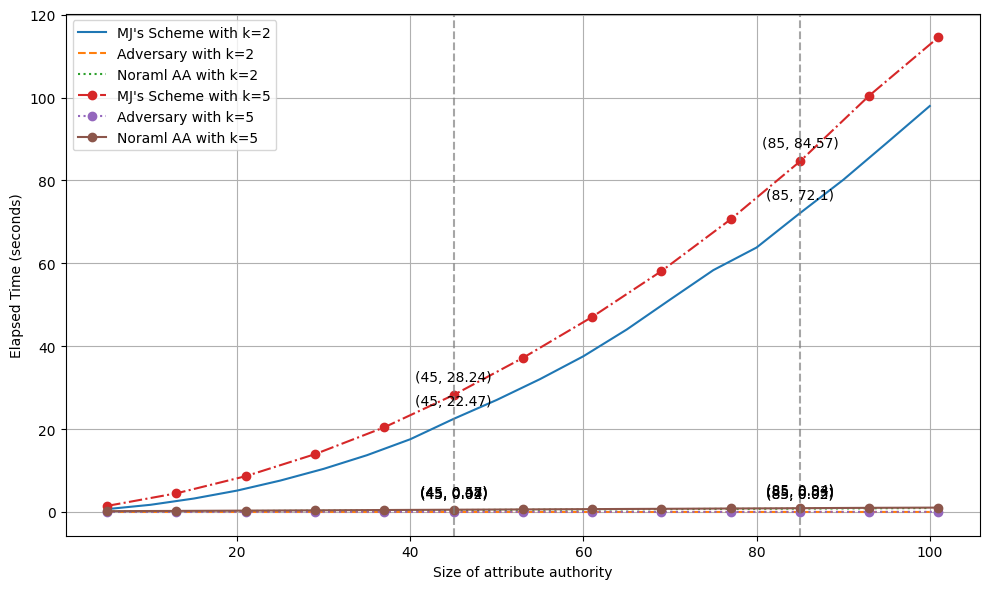

In [9]:
plot_linestyle(ks, xs, ys, sp_xs, sp_ys, ["MJ's Scheme", "Adversary", "Noraml AA"])

### Comparsion

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comp(ks, xss, ys, comp_ys, labels,label_size = 18, legend_size = 18):
    plt.figure(figsize=(10, 6))

    linestyles = ['-', '-.','--', ':']

    # Plotting the subsequent data sets and calculating differences for Compare Set 1
    for i, k, y, y_,  style in zip(range(len(ks)), ks, ys, comp_ys, linestyles):
        plt.plot(xss[i], y, label=f'CP{i+1}: {labels[0]} with k={k}', linestyle=style)
        plt.plot(xss[i], y_, label=f'CP{i+1}: {labels[1]} with k={k}', linestyle=style, alpha=0.7)

        plt.fill_between(xss[i], y, y_, color='gray', alpha=0.2)

        diff = (np.array(y_) - np.array(y)) / np.array(y) * 100
        avg_increase = np.mean(diff)

        # Finding the midpoint for annotation
        mid_index = len(xss[i]) // 2  # Finding the index at the middle of the dataset
        mid_x = xss[i][mid_index]  # X-coordinate at the midpoint
        mid_y = (y[mid_index] + y_[mid_index]) / 2  # Average Y-coordinate at the midpoint

        plt.annotate(f'Avg. increase: {avg_increase:.2f}%', xy=(mid_x, mid_y-5), textcoords='data', ha='center', size= 25)

    plt.xlabel('Number of attribute authority', fontsize = label_size)
    plt.ylabel('Time Cost (seconds)', fontsize = label_size)
    plt.legend(prop={'size': legend_size})
    plt.grid(True)
    plt.tight_layout()
    #plt.title(title)
    plt.show()


In [42]:
ks = [2,10]

xs = range(5,65,3)
comp_xs = range(5,65,5)
ys = []
comp_ys = []
ys.append([d['total'] for d in datasets[str(ks[0])]['seq']])
#ys.append([d['ad_setup'] + d['ad_keygen'] + d['ad_decrypt'] for d in datasets[str(ks[0])]['seq']])
comp_ys.append([d['total'] + d['prove'] + d['verify'] for d in datasets[str(ks[0])]['seq']])

ys.append([d['total'] for d in datasets[str(ks[1])]['seq']])
#sp_ys.append([d['ad_setup'] + d['ad_keygen'] + d['ad_decrypt'] for d in datasets[str(ks[1])]['seq']])
comp_ys.append([d['total'] + d['prove'] + d['verify'] for d in datasets[str(ks[1])]['seq']])

# ys.append([d['total'] for d in datasets[str(ks[2])]['seq']])
# comp_ys.append([d['total'] + d['prove'] + d['verify'] for d in datasets[str(ks[2])]['seq']])

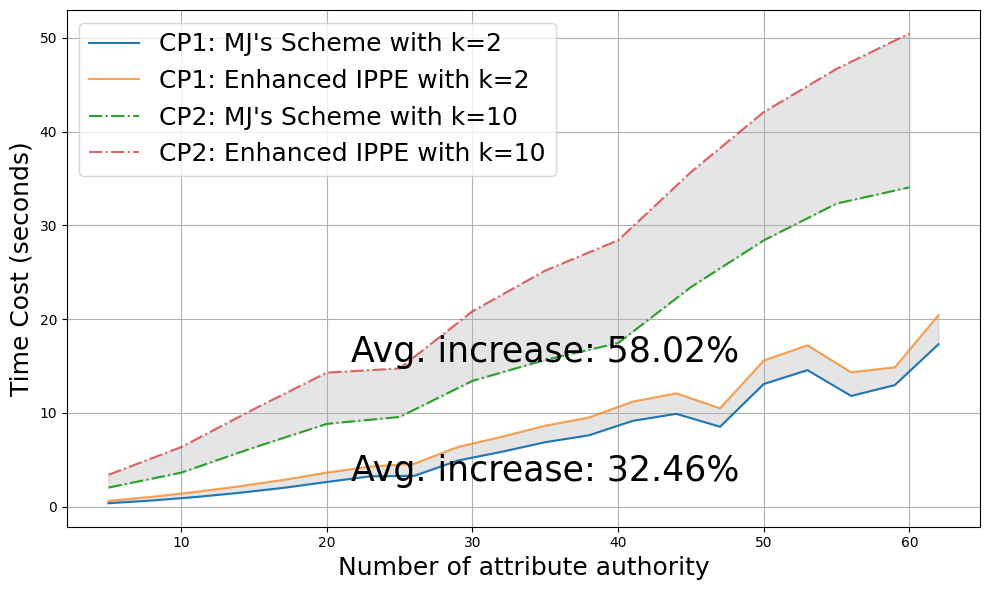

In [43]:
plot_comp(ks, [xs, comp_xs, comp_xs], ys, comp_ys, ["MJ's Scheme", 'Enhanced IPPE'])#, "Compare Cost for Original Scheme and our Enhanced IPPE")